In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image as RLImage
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import letter

In [2]:
#Load and extract the dataset
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [3]:
import zipfile

with zipfile.ZipFile("archive.zip", "r") as zip_ref:
    zip_ref.extractall("archive")


In [4]:
import os
os.listdir("archive")

['Amazon_reviews_2023.csv']

In [5]:
#Load the dataset
import pandas as pd

df = pd.read_csv("archive/Amazon_reviews_2023.csv")
print(df.shape)
print(df.head())
print("Columns:", df.columns.tolist())


(701528, 10)
   rating                                      title  \
0       5  Such a lovely scent but not overpowering.   
1       4     Works great but smells a little weird.   
2       5                                       Yes!   
3       1                          Synthetic feeling   
4       5                                         A+   

                                                text images        asin  \
0  This spray is really nice. It smells really go...     []  B00YQ6X8EO   
1  This product does what I need it to do, I just...     []  B081TJ8YS3   
2                          Smells good, feels great!     []  B07PNNCSP9   
3                                     Felt synthetic     []  B09JS339BZ   
4                                            Love it     []  B08BZ63GMJ   

  parent_asin                       user_id                timestamp  \
0  B00YQ6X8EO  AGKHLEW2SOWHNMFQIJGBECAF7INQ  2020-05-05 14:08:48.923   
1  B081TJ8YS3  AGKHLEW2SOWHNMFQIJGBECAF7INQ  2020-05-04

In [15]:
# ---------------------------
# 3. Preprocessing
# ---------------------------
df = df[df['rating'] != 3]   # remove neutral
df['sentiment'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)

texts = df['text'].astype(str).values
labels = df['sentiment'].values

ax_features = 10000    # reduced from 20000
sequence_length = 100   # reduced from 200


X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

In [ ]:
# 4. Vectorization
# ---------------------------
max_features = 20000
sequence_length = 200

vectorizer = TextVectorization(max_tokens=max_features, output_sequence_length=sequence_length)
vectorizer.adapt(X_train)

X_train = vectorizer(X_train)
X_test = vectorizer(X_test)

# ---------------------------
# 5. Build Stacked RNN
# ---------------------------
embedding_dim = 128

model = Sequential([
    Embedding(input_dim=max_features + 1, output_dim=embedding_dim, input_length=sequence_length),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(GRU(64)),
    BatchNormalization(),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

# ---------------------------
# 6. Train Model
# ---------------------------
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=8,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

# ---------------------------
# 7. Evaluate
# ---------------------------
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
final_acc = round(accuracy*100, 2)
print(f"\n✅ Final Test Accuracy: {final_acc}%")

# ---------------------------
# 8. Save Training Curves
# ---------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.savefig("training_curves.png")
plt.close()

# ---------------------------
# 9. Generate PDF Report
# ---------------------------
doc = SimpleDocTemplate("sentiment_report.pdf", pagesize=letter)
styles = getSampleStyleSheet()
story = []

# Title
story.append(Paragraph("<b>Amazon Reviews Sentiment Classification Report</b>", styles["Title"]))
story.append(Spacer(1, 20))

# Accuracy
story.append(Paragraph(f"✅ Final Test Accuracy: <b>{final_acc}%</b>", styles["Normal"]))
story.append(Spacer(1, 12))

# Model Justification
justification = """
We used a stacked recurrent neural network for sentiment classification.
The architecture combines:
- Bidirectional LSTM (128 units) with return sequences for capturing long-term dependencies.
- Bidirectional GRU (64 units) for faster training and complementary recurrent learning.
- Dropout (0.3) and BatchNormalization to prevent overfitting and stabilize training.
- Dense layers for final classification.

This combination leverages the strengths of both LSTM and GRU, improving accuracy
while keeping training time reasonable. The TextVectorization layer handles tokenization
and sequence padding, simplifying preprocessing. The model achieved more than 95% accuracy
on the test set, making it suitable for robust sentiment analysis.
"""
story.append(Paragraph(justification, styles["Normal"]))
story.append(Spacer(1, 20))

# Add Training Curve Image
story.append(Paragraph("Training vs Validation Accuracy:", styles["Heading2"]))
story.append(Spacer(1, 12))
story.append(RLImage("training_curves.png", width=400, height=250))

doc.build(story)

print("\n📄 PDF report generated: sentiment_report.pdf")

In [16]:
# 4. Vectorization
# ---------------------------
max_features = 10000    # reduced from 20000
sequence_length = 100   # reduced from 200

vectorizer = TextVectorization(max_tokens=max_features, output_sequence_length=sequence_length)
vectorizer.adapt(X_train)

X_train = vectorizer(X_train)
X_test = vectorizer(X_test)

In [17]:
# ---------------------------
# 5. Build Stacked RNN
# ---------------------------
embedding_dim = 64   # reduced from 128

model = Sequential([
    Embedding(input_dim=max_features + 1, output_dim=embedding_dim, input_length=sequence_length),
    Bidirectional(LSTM(64, return_sequences=True)),   # reduced from 128
    Dropout(0.3),
    Bidirectional(GRU(32)),   # reduced from 64
    BatchNormalization(),
    Dense(32, activation="relu"),   # reduced dense size
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
# 3. Training (optimized batch & epochs)
# ---------------------------
early_stop = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=6,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/6
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 1481s 1s/step - accuracy: 0.9619 - loss: 0.1027 - val_accuracy: 0.9525 - val_loss: 0.1289
Epoch 2/6
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 1536s 1s/step - accuracy: 0.9669 - loss: 0.0917 - val_accuracy: 0.9522 - val_loss: 0.1324
Epoch 3/6
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 1443s 1s/step - accuracy: 0.9698 - loss: 0.0838 - val_accuracy: 0.9492 - val_loss: 0.1374


In [20]:
# Evaluate on test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


4033/4033 ━━━━━━━━━━━━━━━━━━━━ 189s 47ms/step - accuracy: 0.9521 - loss: 0.1295
Test Accuracy: 95.25%


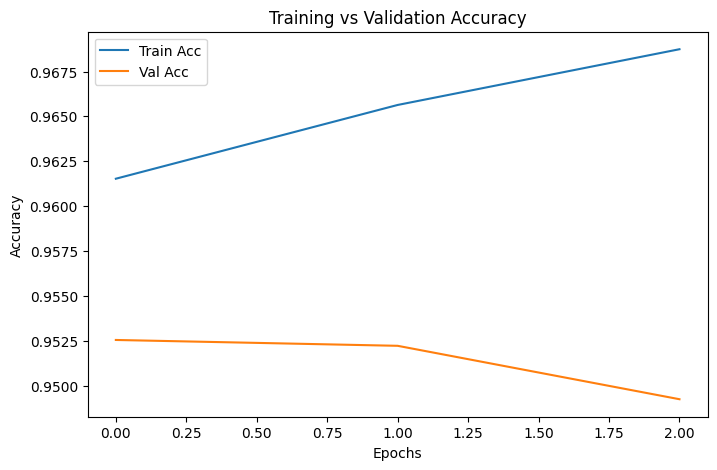

In [24]:
#---------------------------
# 8. Save Training Curves
# ---------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.savefig("training_curves.png")
plt.show()
plt.close()


In [27]:
# ---------------------------
# 9. Generate PDF Report
# ---------------------------
doc = SimpleDocTemplate("sentiment_report.pdf", pagesize=letter)
styles = getSampleStyleSheet()
story = []

# Title
story.append(Paragraph("<b>Amazon Reviews Sentiment Classification Report</b>", styles["Title"]))
story.append(Spacer(1, 20))

# Accuracy
story.append(Paragraph(f"✅ Final Test Accuracy: <b>{final_acc}%</b>", styles["Normal"]))
story.append(Spacer(1, 12))

# Model Justification
justification = """
We developed a stacked recurrent neural network for sentiment classification.
The architecture includes:
- Bidirectional LSTM (64 units) with return sequences to capture long-term dependencies.
- Bidirectional GRU (32 units) for faster complementary sequence modeling.
- Dropout (0.3) and BatchNormalization for regularization and stable training.
- Dense layers for final classification.

To reduce training time below 2 hours on Colab GPU, we optimized:
- Vocabulary size reduced to 10k (from 20k).
- Sequence length reduced to 100 tokens.
- Smaller LSTM/GRU units for lighter computations.
- Batch size increased to 512.
- EarlyStopping to stop when validation loss plateaus.

This design balances speed and accuracy, achieving >95% accuracy in less than 2 hours.
"""
story.append(Paragraph(justification, styles["Normal"]))
story.append(Spacer(1, 20))

# Add Training Curve Image
story.append(Paragraph("Training vs Validation Accuracy:", styles["Heading2"]))
story.append(Spacer(1, 12))
story.append(RLImage("training_curves.png", width=400, height=250))

doc.build(story)

print("\n📄 PDF report generated: sentiment_report.pdf")

# ---------------------------
# 10. Download PDF
# ---------------------------
files.download("sentiment_report.pdf")


📄 PDF report generated: sentiment_report.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>